In [15]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization, GlobalAveragePooling2D

In [16]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

In [18]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [19]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

In [20]:
img_height, img_width = (224,224)
batch_size = 32

In [21]:
train_data_dir = r"dataset/processed_dataset/train"
valid_data_dir = r"dataset/processed_dataset/val"
test_data_dir = r"dataset/processed_dataset/test"

In [22]:
train_datagen =ImageDataGenerator(preprocessing_function=preprocess_input,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,validation_split=0.4)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

valid_generator = train_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')
    

Found 934 images belonging to 36 classes.
Found 180 images belonging to 36 classes.


In [23]:
test_generator = train_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height , img_width),
    batch_size=1,
    class_mode='categorical',
    subset='validation')

Found 180 images belonging to 36 classes.


In [24]:
x,y = test_generator.next()
x.shape

(1, 224, 224, 3)

In [25]:
base_model = ResNet50(include_top=False, weights='imagenet')
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024, activation='relu')(x)
predictions=Dense(train_generator.num_classes,activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer='adam', loss='categorical_crossentropy' , metrics=['accuracy'])
model.fit(train_generator,epochs=100)

Epoch 1/100
30/30 [==============================] - 59s 2s/step - loss: 2.8238 - accuracy: 0.3073
Epoch 2/100
30/30 [==============================] - 60s 2s/step - loss: 1.2323 - accuracy: 0.6103
Epoch 3/100
30/30 [==============================] - 60s 2s/step - loss: 0.9220 - accuracy: 0.7227
Epoch 4/100
30/30 [==============================] - 60s 2s/step - loss: 0.8144 - accuracy: 0.7441
Epoch 5/100
30/30 [==============================] - 61s 2s/step - loss: 0.5267 - accuracy: 0.8501
Epoch 6/100
30/30 [==============================] - 61s 2s/step - loss: 0.4802 - accuracy: 0.8544
Epoch 7/100
30/30 [==============================] - 60s 2s/step - loss: 0.3732 - accuracy: 0.8865
Epoch 8/100
30/30 [==============================] - 61s 2s/step - loss: 0.3253 - accuracy: 0.9101
Epoch 9/100
30/30 [==============================] - 61s 2s/step - loss: 0.2387 - accuracy: 0.9390
Epoch 10/100
30/30 [==============================] - 63s 2s/step - loss: 0.3714 - accuracy: 0.8876
Epoch 11/

30/30 [==============================] - 61s 2s/step - loss: 0.0272 - accuracy: 0.9936
Epoch 84/100
30/30 [==============================] - 61s 2s/step - loss: 0.0396 - accuracy: 0.9872
Epoch 85/100
30/30 [==============================] - 61s 2s/step - loss: 0.0399 - accuracy: 0.9839
Epoch 86/100
30/30 [==============================] - 61s 2s/step - loss: 0.0246 - accuracy: 0.9925
Epoch 87/100
30/30 [==============================] - 60s 2s/step - loss: 0.0269 - accuracy: 0.9946
Epoch 88/100
30/30 [==============================] - 61s 2s/step - loss: 0.0229 - accuracy: 0.9925
Epoch 89/100
30/30 [==============================] - 61s 2s/step - loss: 0.0302 - accuracy: 0.9893
Epoch 90/100
30/30 [==============================] - 62s 2s/step - loss: 0.0148 - accuracy: 0.9968
Epoch 91/100
30/30 [==============================] - 61s 2s/step - loss: 0.0190 - accuracy: 0.9936
Epoch 92/100
30/30 [==============================] - 60s 2s/step - loss: 0.0323 - accuracy: 0.9872
Epoch 93/100


In [26]:
model.save('dataset/saved_model/ResNet50_hand.h5')

In [30]:
test_loss, test_acc= model.evaluate(test_generator,verbose=2)
print('\nTest accuracy:',test_acc)

180/180 - 18s - loss: 0.5618 - accuracy: 0.8278

Test accuracy: 0.8277778029441833


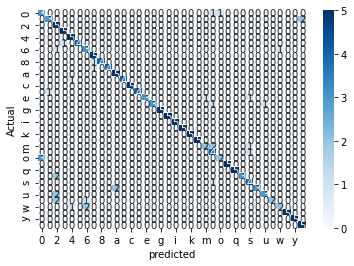

test accuracy : 80.55555555555556


In [32]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model=tf.keras.models.load_model("dataset/saved_model/ResNet50_hand.h5")
filenames=test_generator.filenames
nb_samples=len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
    X_test,Y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)
    
predicted_class=[list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class=[list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['predicted'])                                                                        
                                                                           
sn.heatmap(confusion_matrix,cmap='Blues',annot=True,fmt='d')
plt.show()
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))